# Slope Scout : Optimal NY State Ski Resort Route 

Slope Scout provides the optimal route through 9 of NY state's premier ski resorts and areas, providing thrill seekers and easy riders with the shortest and most efficient route for their winter adventure. Leveraging straightforward algorithms, geospatial visualizations, and a webpage for user interaction, you can put your mind at ease and just follow the path to your next powder adventure.

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import time

from geopy.geocoders import Nominatim
import random
import requests
from bs4 import BeautifulSoup

import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
import polyline

import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Data Ingest & Initial Processing

## Data Sourcing
For the purpose of optimizing routes for ski resorts and areas in New York state. The names of these areas are to be parsed from the following website.

[Ski Central]('https://www.skicentral.com/') - A popular site to review popular ski destinations worldwide.



## Data Description & Overview

- **name**: name of the resort as it appears on the web source.
- **url**: URL of the resort or ski area as presented on the web source.
- **vertical_rise**: a measurement of the total elevation change a skier descends from the highest point to the lowest point on a ski run.
- **base_elevation**: a measurment of the altitude at the bottom of the ski resort or ski area, essentially the lowest point of on the mountain accessable to skiers.
- **summit_elevation**: a measurement of the height above sea level of the highest point on a mountain.
- **annual_snowfall**: the total amount of snow that falls over the course of a year.
- **number_of_trails**: the total number of trails on the mountain
- **skiable_acres**: the amount of terrain that is accessible by ski.
- **longest_run**: a measurement refering to a continuous downhill ski slope that covers the greatest distance from top to bottom on a mountain.
- **snowmaking**: a measurement or indication that the ski resort or area creates artifical snow for the purpose producing snow when natural snowfall is limited.
- **latitude**: decimal latitude of resort location.
- **longitude**: decimal longitude of resort location.
- **address**: geolocated address based on query "`name`, NY".

### Overview

The foundation of the dataset are the resort names, which are collected by scraping the [Ski Central]('https://www.skicentral.com/') website. For the purposes of this optimization, we have restricted the area selection to New York state, the state with the most ski resorts and areas in the US. Obtaining these names and their location data is a straight forward procedure.

### Parse and collect resort data
In order to obtain the mountain statistics located a link deep at each of the `resort_item`s, we must find the associated hyperlink. There is no universal formatting for how the links are named throughout the resort items, so obtaining the link directly in this fashion is necessary over determining it directly from the resort name. From this scraping procedure the mountain/resort name and child url are stored as a dictionary.

### Geolocation of resorts and ski areas
Utilizing the **Nominatim geocoder** provided by the geopy library and based on OpenStreetMap data, the query `{resort name}, NY` is processed and the location data for each resort that is available from the query is returned. The location data that is retrieved is `latitude`, `longitude`, and the `address`. The address of the geolocated data was collected just to quickly verify the city of each of the locations. Once this is completed all of the data is then organized into a DataFrame which can be utilized for analysis and route building.

In [2]:
# web scraping (get resort names)

base_url = "https://www.skicentral.com"
response = requests.get(f"{base_url}/newyork.html")
soup = BeautifulSoup(response.text, 'html.parser')

resort_titles = soup.find_all('div', class_='resorttitle')
resort_names = [title.text.strip() for title in resort_titles]
print(resort_titles)
print(resort_names)

[<div class="resorttitle"><a href="whiteface.html">Whiteface Mountain</a></div>, <div class="resorttitle"><a href="goremountain.html">Gore Mountain</a></div>, <div class="resorttitle"><a href="huntermountain.html">Hunter Mountain</a></div>, <div class="resorttitle"><a href="belleayre.html">Belleayre Mountain</a></div>, <div class="resorttitle"><a href="holidayvalley.html">Holiday Valley</a></div>, <div class="resorttitle"><a href="skiwindham.html">Windham Mountain</a></div>, <div class="resorttitle"><a href="greekpeak.html">Greek Peak</a></div>, <div class="resorttitle"><a href="catamount.html">Catamount Ski Area</a></div>, <div class="resorttitle"><a href="peeknpeak.html">Peek'n Peak Resort</a></div>, <div class="resorttitle"><a href="holimont.html">HoliMont</a></div>, <div class="resorttitle"><a href="beartownskiarea.html">Beartown Ski Area</a></div>, <div class="resorttitle"><a href="brantlingskiandsnowboardcenter.html">Brantling Ski and Snowboard Center</a></div>, <div class="resor

In [3]:
# parse and collect resort names and child links

resorts = []
for title in resort_titles:
    link = title.find('a')
    resort_url = base_url + "/" + link.get('href')
    resorts.append({
    'name': title.text.strip(),
    'url': resort_url})
    
print(resorts)

[{'name': 'Whiteface Mountain', 'url': 'https://www.skicentral.com/whiteface.html'}, {'name': 'Gore Mountain', 'url': 'https://www.skicentral.com/goremountain.html'}, {'name': 'Hunter Mountain', 'url': 'https://www.skicentral.com/huntermountain.html'}, {'name': 'Belleayre Mountain', 'url': 'https://www.skicentral.com/belleayre.html'}, {'name': 'Holiday Valley', 'url': 'https://www.skicentral.com/holidayvalley.html'}, {'name': 'Windham Mountain', 'url': 'https://www.skicentral.com/skiwindham.html'}, {'name': 'Greek Peak', 'url': 'https://www.skicentral.com/greekpeak.html'}, {'name': 'Catamount Ski Area', 'url': 'https://www.skicentral.com/catamount.html'}, {'name': "Peek'n Peak Resort", 'url': 'https://www.skicentral.com/peeknpeak.html'}, {'name': 'HoliMont', 'url': 'https://www.skicentral.com/holimont.html'}, {'name': 'Beartown Ski Area', 'url': 'https://www.skicentral.com/beartownskiarea.html'}, {'name': 'Brantling Ski and Snowboard Center', 'url': 'https://www.skicentral.com/brantlin

In [4]:
# Geolocation of resorts and ski areas

geolocator = Nominatim(user_agent="DCJT3_NY_SKI")

for resort in resorts:
    location = geolocator.geocode(f"{resort['name']}, NY")
    if location:
        resort['latitude'] = location.latitude
        resort['longitude'] = location.longitude
        resort['address'] = location.address

    # Mountain stats scrape
    response = requests.get(resort['url'])
    resort_soup = BeautifulSoup(response.text, 'html.parser')
    stats_table = resort_soup.find('table', id='mountainstatistics')

    for row in stats_table.find_all('tr'):
        cols = row.find_all(['td', 'th'])
        if len(cols) == 2:
            stat_name = cols[0].text.strip().lower().replace(' ', '_')
            stat_value = cols[1].text.strip()
            resort[stat_name] = stat_value
    
time.sleep(1)

df = pd.DataFrame(resorts)
df.head()

,name,url,latitude,longitude,address,vertical_rise,base_elevation,summit_elevation,annual_snowfall,number_of_trails,skiable_acres,longest_run,snowmaking
0,Whiteface Mountain,https://www.skicentral.com/whiteface.html,44.365784,-73.902984,"Whiteface Mountain, Essex County, New York, Un...",3430 ft,1220 ft,4650 ft,190 inches,90,288,2.1 miles / 3.4 km,98%
1,Gore Mountain,https://www.skicentral.com/goremountain.html,43.672954,-74.048853,"Gore Mountain, Town of Johnsburg, Warren Count...",2537 ft,998 ft,3600 ft,150 inches,107,439,4.4 miles / 7.1 km,97%
2,Hunter Mountain,https://www.skicentral.com/huntermountain.html,42.177866,-74.230422,"Hunter Mountain, Town of Hunter, Greene County...",1600 ft,1600 ft,3200 ft,125 inches,58,240,n/a,100%
3,Belleayre Mountain,https://www.skicentral.com/belleayre.html,42.126893,-74.474075,"Belleayre Mountain Day Use Area, Pine Hill, To...",1404 ft,2025 ft,3429 ft,141 inches,50,171,n/a,96%
4,Holiday Valley,https://www.skicentral.com/holidayvalley.html,42.263145,-78.663611,"Holiday Valley, Town of Ellicottville, Cattara...",750 ft,1500 ft,2250 ft,180 inches,58,290,0.8 miles / 1.3 km,95%


# Data Processing

In [5]:
df_clean = df.dropna(subset=['latitude', 'longitude'])
df_clean['vertical_rise_num'] = df_clean['vertical_rise'].str.replace(' ft', '').astype(float)

df_clean.loc[:,'base_elevation'] = pd.to_numeric(df_clean['base_elevation'].str.replace(' ft', '', regex=False), errors='coerce', downcast="integer")
df_clean.loc[:,'summit_elevation'] = pd.to_numeric(df_clean['summit_elevation'].str.replace(' ft', '', regex=False), errors='coerce', downcast="integer")
df_clean.loc[:,'annual_snowfall'] = pd.to_numeric(df_clean['annual_snowfall'].str.replace(' inches', '', regex=False), errors='coerce', downcast="integer")
df_clean.loc[:,'number_of_trails'] = pd.to_numeric(df_clean['number_of_trails'], errors='coerce', downcast="integer")
df_clean.loc[:,'skiable_acres'] = pd.to_numeric(df_clean['skiable_acres'], errors='coerce', downcast="integer")

df_filtered = df_clean[df_clean['name'] != 'HoliMont'] # removed, too close to Holiday Valley (higher elevation)
top_9 = df_filtered.head(9)
top_9

/tmp/ipykernel_7343/2156516501.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['vertical_rise_num'] = df_clean['vertical_rise'].str.replace(' ft', '').astype(float)


,name,url,latitude,longitude,address,vertical_rise,base_elevation,summit_elevation,annual_snowfall,number_of_trails,skiable_acres,longest_run,snowmaking,vertical_rise_num
0,Whiteface Mountain,https://www.skicentral.com/whiteface.html,44.365784,-73.902984,"Whiteface Mountain, Essex County, New York, Un...",3430 ft,1220.0,4650.0,190.0,90,288.0,2.1 miles / 3.4 km,98%,3430.0
1,Gore Mountain,https://www.skicentral.com/goremountain.html,43.672954,-74.048853,"Gore Mountain, Town of Johnsburg, Warren Count...",2537 ft,998.0,3600.0,150.0,107,439.0,4.4 miles / 7.1 km,97%,2537.0
2,Hunter Mountain,https://www.skicentral.com/huntermountain.html,42.177866,-74.230422,"Hunter Mountain, Town of Hunter, Greene County...",1600 ft,1600.0,3200.0,125.0,58,240.0,n/a,100%,1600.0
3,Belleayre Mountain,https://www.skicentral.com/belleayre.html,42.126893,-74.474075,"Belleayre Mountain Day Use Area, Pine Hill, To...",1404 ft,2025.0,3429.0,141.0,50,171.0,n/a,96%,1404.0
4,Holiday Valley,https://www.skicentral.com/holidayvalley.html,42.263145,-78.663611,"Holiday Valley, Town of Ellicottville, Cattara...",750 ft,1500.0,2250.0,180.0,58,290.0,0.8 miles / 1.3 km,95%,750.0
5,Windham Mountain,https://www.skicentral.com/skiwindham.html,42.293926,-74.261312,"Windham Mountain Club, Town of Windham, Greene...",1600 ft,1500.0,3100.0,105.0,54,285.0,n/a,97%,1600.0
6,Greek Peak,https://www.skicentral.com/greekpeak.html,42.502320,-76.148046,"Greek Peak Mountain Resort, 2000, South Hill R...",952 ft,1148.0,2100.0,122.0,38,220.0,1.5 miles / 2.4 km,83%,952.0
8,Peek'n Peak Resort,https://www.skicentral.com/peeknpeak.html,42.060463,-79.744066,"Peek'n Peak Resort, Abbey Lane, Town of French...",400 ft,1400.0,1800.0,200.0,27,105.0,0 miles / 1 km,100%,400.0
10,Beartown Ski Area,https://www.skicentral.com/beartownskiarea.html,44.764111,-73.584055,"Beartown Ski Area, Beartown Road, Beartown, To...",150 ft,NaN,NaN,NaN,9,NaN,n/a,yes,150.0


In [32]:
fig = px.scatter_mapbox(df_filtered[:9], 
                       lat='latitude', 
                       lon='longitude',
                       text='name',
                       hover_name='name',
                       mapbox_style='carto-positron')

# Update the layout to center on NY
fig.update_layout(
    title='Selected New York Ski Resorts',
    mapbox=dict(
        center=dict(lat=43.2994, lon=-74.2179),  # Center of NY State
        zoom=6
    ),
    margin=dict(l=0, r=0, t=30, b=0),
    width=1000,
    height=700
)

fig.update_traces(
    mode='markers+text',
    textfont=dict(size=12),
    textposition='bottom right')

fig.show()

# Exploratory Data Analysis

This analysis aims to explore the characteristics of the top 9 ski resorts in the United States. The dataset contains information on various attributes such as base elevation, summit elevation, annual snowfall, number of trails, and skiable acres.

#### Distribution of Annual Snowfall
-------------------------------

The histogram of annual snowfall shows a skewed distribution, with most resorts receiving between 100-300 inches of snowfall per year.

##### KDE of Annual Snowfall
----------------------

The KDE (Kernel Density Estimate) plot of annual snowfall provides a smoothed estimate of the underlying distribution. The KDE plot can be interpreted as follows:

*   The x-axis represents the annual snowfall values.
    
*   The y-axis represents the density of the data points.
    
*   The peak of the curve indicates the most common annual snowfall value.
    
*   The width of the curve indicates the spread of the data points.
    

In this case, the KDE plot shows a peak around 200 inches, indicating that most resorts receive around 200 inches of snowfall per year.

#### Relationship between Base Elevation and Annual Snowfall
-------------------------------------------------------

The scatter plot of base elevation vs annual snowfall shows a positive correlation, indicating that resorts with higher base elevations tend to receive more snowfall.

##### KDE of Base Elevation vs Annual Snowfall
----------------------------------------

The KDE plot of base elevation vs annual snowfall provides a smoothed estimate of the joint distribution. The KDE plot can be interpreted as follows:

*   The x-axis represents the base elevation values.
    
*   The y-axis represents the annual snowfall values.
    
*   The color of the plot represents the density of the data points.
    
*   The darker colors indicate higher density, while the lighter colors indicate lower density.
    

In this case, the KDE plot shows a positive relationship between base elevation and annual snowfall, indicating that resorts with higher base elevations tend to receive more snowfall.

#### Relationship between Summit Elevation and Annual Snowfall
---------------------------------------------------------
The scatter plot of summit elevation vs annual snowfall also shows a positive correlation, indicating that resorts with higher summit elevations tend to receive more snowfall.

##### KDE of Summit Elevation vs Annual Snowfall
------------------------------------------

The KDE plot of summit elevation vs annual snowfall provides a smoothed estimate of the joint distribution. The interpretation of the KDE plot is similar to the previous one.

#### Number of Trails by Resort
--------------------------

The bar chart of number of trails by resort shows that some resorts have significantly more trails than others.

#### Vertical Rise vs Annual Snowfall
--------------------------------

The scatter plot of vertical rise vs annual snowfall shows a positive correlation, indicating that resorts with greater vertical rise tend to receive more snowfall.

#### KDE of Vertical Rise vs Annual Snowfall
---------------------------------------

The KDE plot of vertical rise vs annual snowfall provides a smoothed estimate of the joint distribution. The interpretation of the KDE plot is similar to the previous ones with vertical rise 1000 - 2000 ft being the densest.

#### Correlation Matrix
------------------

The correlation matrix shows the relationships between various attributes. The strongest correlation is between summit elevation and vertical rise.

This analysis provides insights into the characteristics of the top 9 ski resorts in the United States and can inform decisions on which resorts to visit based on individual preferences.

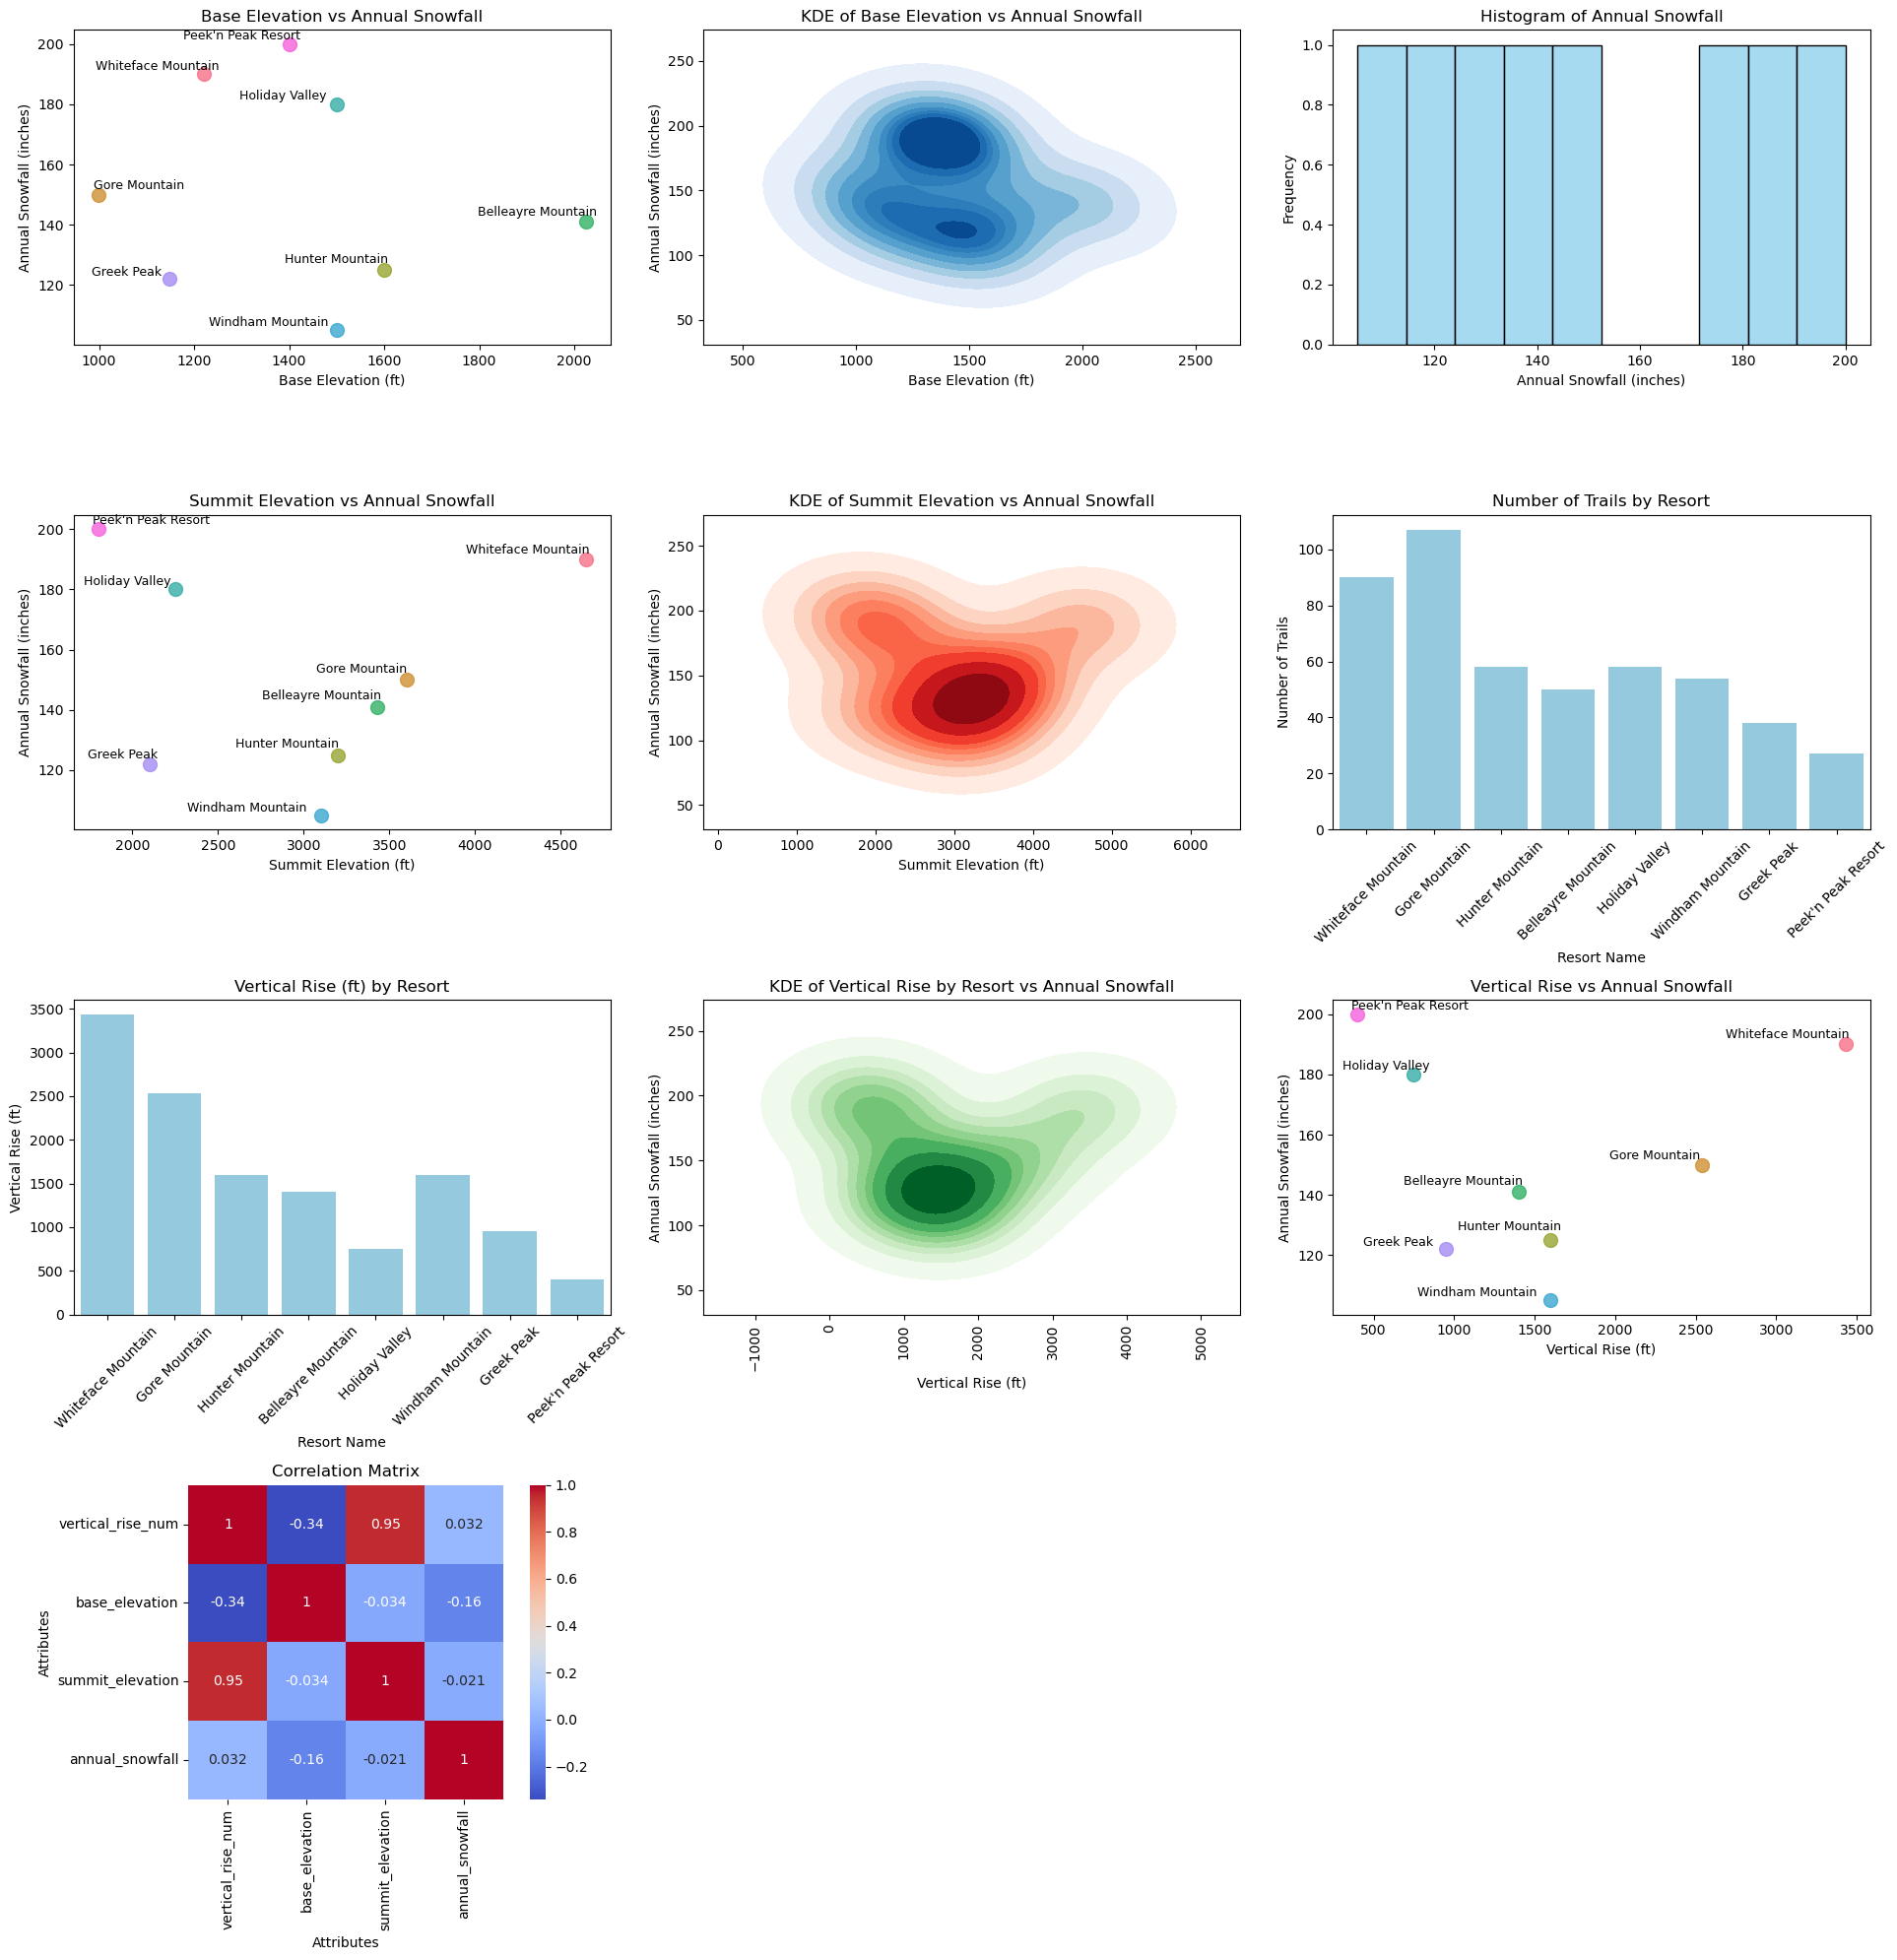

In [7]:
top_9_cleaned = top_9.dropna(subset=['base_elevation', 'summit_elevation', 'annual_snowfall', 'vertical_rise_num', 'skiable_acres'])
top_9_cleaned = top_9_cleaned[(top_9_cleaned['base_elevation'].notnull()) &
                              (top_9_cleaned['summit_elevation'].notnull()) &
                              (top_9_cleaned['annual_snowfall'].notnull()) &
                              (top_9_cleaned['vertical_rise_num'].notnull()) &
                              (top_9_cleaned['skiable_acres'].notnull())]

# Define unique colors and labels for each resort
resorts = top_9_cleaned['name'].unique()
colors = sns.color_palette("husl", len(resorts)) # Generate distinct colors
labels = [resort for resort in resorts] # Use resort names as labels

# Create a dictionary to map resort names to color and label
resort_style = {resort: (colors[i], labels[i]) for i, resort in enumerate(resorts)}

# Create a figure with a 4 * 3 grid of subplots
fig = plt.figure(figsize=(20, 20))
gs = gridspec.GridSpec(4, 3)

# Plot 1: Scatter plot for Base Elevation vs Annual Snowfall
ax1 = fig.add_subplot(gs[0, 0])
ax = ax1
texts = []

# Set up the scatter plots and annotations
for resort, style in resort_style.items():
    data = top_9_cleaned[top_9_cleaned['name'] == resort]
    scatter = ax.scatter(data['base_elevation'], data['annual_snowfall'],
                            color=style[0], label=style[1], s=100, alpha=0.8)

    # Animate the points with resort names using adjustText
    for i in range(len(data)):
        texts.append(plt.text(data['base_elevation'].iloc[i], data['annual_snowfall'].iloc[i],
                                  data['name'].iloc[i], fontsize=9, ha='right', va='bottom'))

# Adjust text positions to avoid overlap
adjust_text(texts, ax=ax, only_move={'points': 'y', 'texts': 'xy'}, force_points=0.2, force_text=0.2)

ax.set_title('Base Elevation vs Annual Snowfall')
ax.set_xlabel('Base Elevation (ft)')
ax.set_ylabel('Annual Snowfall (inches)')

# Plot 2: KDE for Base Elevation vs Annual Snowfall
ax2 = fig.add_subplot(gs[0, 1])
sns.kdeplot(data=top_9_cleaned, x='base_elevation', y='annual_snowfall', fill=True, cmap='Blues')
ax2.set_title('KDE of Base Elevation vs Annual Snowfall')
ax2.set_xlabel('Base Elevation (ft)')
ax2.set_ylabel('Annual Snowfall (inches)')

# Plot 3: Histogram of Annual Snowfall
ax3 = fig.add_subplot(gs[0, 2])
sns.histplot(data=top_9_cleaned, x='annual_snowfall', bins=10, color='skyblue')
ax3.set_title('Histogram of Annual Snowfall')
ax3.set_xlabel('Annual Snowfall (inches)')
ax3.set_ylabel('Frequency')

# Plot 4: Scatter plot for Summit Elevation vs Annual Snowfall
ax4 = fig.add_subplot(gs[1, 0])
ax = ax4
texts = []

# Set up the scatter plots and annotations
for resort, style in resort_style.items():
    data = top_9_cleaned[top_9_cleaned['name'] == resort]
    scatter = ax.scatter(data['summit_elevation'], data['annual_snowfall'],
                            color=style[0], label=style[1], s=100, alpha=0.8)

    # Animate the points with resort names using adjustText
    for i in range(len(data)):
        texts.append(plt.text(data['summit_elevation'].iloc[i], data['annual_snowfall'].iloc[i],
                                  data['name'].iloc[i], fontsize=9, ha='right', va='bottom'))

# Adjust text positions to avoid overlap
adjust_text(texts, ax=ax, only_move={'points': 'y', 'texts': 'xy'}, force_points=0.2, force_text=0.2)

ax.set_title('Summit Elevation vs Annual Snowfall')
ax.set_xlabel('Summit Elevation (ft)')
ax.set_ylabel('Annual Snowfall (inches)')

# Plot 5: KDE for Summit Elevation vs Annual Snowfall
ax5 = fig.add_subplot(gs[1, 1])
sns.kdeplot(data=top_9_cleaned, x='summit_elevation', y='annual_snowfall', fill=True, cmap='Reds')
ax5.set_title('KDE of Summit Elevation vs Annual Snowfall')
ax5.set_xlabel('Summit Elevation (ft)')
ax5.set_ylabel('Annual Snowfall (inches)')

# Plot 6: Bar chart of Number of Trails by Resort
ax6 = fig.add_subplot(gs[1, 2])
sns.barplot(data=top_9_cleaned, x='name', y='number_of_trails', color='skyblue')
ax6.set_title('Number of Trails by Resort')
ax6.set_xlabel('Resort Name')
ax6.set_ylabel('Number of Trails')
ax6.tick_params(axis='x', rotation=45)

# Plot 7: Box plot of Vertical Rise by Resort
ax7 = fig.add_subplot(gs[2, 0])
sns.barplot(data=top_9_cleaned, x='name', y='vertical_rise_num', color='skyblue')
ax7.set_title('Vertical Rise (ft) by Resort')
ax7.set_xlabel('Resort Name')
ax7.set_ylabel('Vertical Rise (ft)')
ax7.tick_params(axis='x', rotation=45)

# Plot 8:

# KDE for Snowfall
ax8 = fig.add_subplot(gs[2, 1])
sns.kdeplot(data=top_9_cleaned, x='vertical_rise_num', y='annual_snowfall', fill=True, cmap='Greens')
ax8.set_title('KDE of Vertical Rise by Resort vs Annual Snowfall')
ax8.set_xlabel('Vertical Rise (ft)')
ax8.set_ylabel('Annual Snowfall (inches)')
ax8.tick_params(axis='x', rotation=90)

# Plot 9: Scatter plot of Vertical Rise vs Annual Snowfall
ax9 = fig.add_subplot(gs[2, 2])
ax = plt.gca()
texts = []

# Set up the scatter plots and annotations
for resort, style in resort_style.items():
    data = top_9_cleaned[top_9_cleaned['name'] == resort]
    scatter = ax.scatter(data['vertical_rise_num'], data['annual_snowfall'],
                            color=style[0], label=style[1], s=100, alpha=0.8)

    # Annotate the points with resort names using adjustText
    for i in range(len(data)):
        texts.append(plt.text(data['vertical_rise_num'].iloc[i], data['annual_snowfall'].iloc[i],
                                  data['name'].iloc[i], fontsize=9, ha='right', va='bottom'))

# Adjust text positions to avoid overlap
adjust_text(texts, ax=ax, only_move={'points': 'y', 'texts': 'xy'}, force_points=0.2, force_text=0.2)

ax.set_title('Vertical Rise vs Annual Snowfall')
ax.set_xlabel('Vertical Rise (ft)')
ax.set_ylabel('Annual Snowfall (inches)')

# Plot 10: Correlation Matrix
ax10 = fig.add_subplot(gs[3, 0])
corr_matrix = top_9_cleaned[['vertical_rise_num', 'base_elevation', 'summit_elevation', 'annual_snowfall']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', square=True)
ax10.set_title('Correlation Matrix')
ax10.set_xlabel('Attributes')
ax10.set_ylabel('Attributes')

plt.tight_layout()
plt.show()

# Random Route Generator

## Open Source Routing Machine

Leveraging the [Open Source Routing Machine]("https://project-osrm.org/") API, the road gemoetries between points are determined. The function below works by utilizing the start and end point `latitude` and `longitude` data to create the driving route between the two points. The request responses expected from these API calls were limited to `Ok` and `NoSegment`. Based on the results presented and all the routes between points returned there were no issues in retrieving the driving route distances and geometries with the given geolocated coordinate data. The returned `distance` data is immediately transformed from meters to miles.

## Random Routing Functionality

The random routing algorithm designed for this experiment is a straightforward system based on the random sampling of a list of numbers based on the size of the provided data frame. The main distinction of this function is that it does select the first point of the route based on the lowest vertical rise. Doing this allows us to best compare random and optimized routing if we are both starting at the same point. The lowest vertical rise is chosen as the first point because one can argue that it would be an easier skiing experience. So the random route is determing by first positioning the lowest vertical rise mountain with a random sample of locations appended ahead of it. A random.seed was placed in order to maintain the same random route between runs and tie together the analysis and the site presentation.

## Route Distance Calculation

The route distance calculation is designed to take a DataFrame and route parameter, which is determined earlier. The main loop of the distance calclation is based on the range of the length of the route minus one, because we are only looking for distances between current and next locations and there is no next location to look for at the last position of the route.

In the main loop, the current point of the route is represented as the start, and the next point in the route is represented as the end. Given these point definitions we can finally leverage the API call for the OSRM API which was defined earlier. These request returns which were defined earlier, are then stored in the `rotue_data` which allows us to then collect the repective distances. these are then appended in dictionary format to `route_details`.

## Random Route Visualization

For the purpose of visualizing the route, the osrm API and the main loop distance calcluation logic is utilized in order to now grab the geometries returned from the original osrm function. These geometries can be represented simply as points in a line which changes directions, with that in mind, the utilization of the polyline library allows these points to be decoded and eventually appended to the `all_route_points` object. This object is further utilized to determine the exact coordinates of each point within the driving route in order to properly plot it within the map object. Utilizing the `lines` mode in this case allows the decoded points to be appropriately presented as "driving routes" within the map.

In [8]:
# Leveraging the Open Source Routing Machine

def osrm_route(start_point, end_point):
    osrm_url = f"http://router.project-osrm.org/route/v1/driving/{start_point[1]},{start_point[0]};{end_point[1]},{end_point[0]}"
    response = requests.get(osrm_url)
    
    data = response.json()
    if data["code"] == "Ok":
        return {
            'distance': data["routes"][0]["distance"] / 1000 * 0.621371,  # meters to miles
            'geometry': data["routes"][0]["geometry"]
        }
    return None

In [9]:
# Random Route Generation

def generate_random_route(df):
    random.seed(12345)

    # Find index with lowest vertical rise
    start_idx = df['vertical_rise_num'].idxmin()
    start_pos = df.index.get_loc(start_idx)

    # Create random route
    locations = list(range(len(df)))
    locations.remove(start_pos)
    route = [start_pos] + random.sample(locations, len(locations))

    return route

In [10]:
# Route Distance Calculation

def calculate_route_distance(df, route):
    total_distance = 0
    route_details = []

    for i in range(len(route)-1):
        start = df.iloc[route[i]]
        end = df.iloc[route[i+1]]

        route_data = osrm_route(
            (start['latitude'], start['longitude']),
            (end['latitude'], end['longitude'])
        )

        total_distance += route_data['distance']
        route_details.append({
            'from': start['name'],
            'to': end['name'],
            'distance': route_data['distance']
        })

    return total_distance, route_details

In [11]:
# Random Route Visualization

def visualize_random_route(df, route, route_details):
    fig = go.Figure()
    all_route_points = []

    # Get route geometries for visualization
    for i in range(len(route)-1):
        start = df.iloc[route[i]]
        end = df.iloc[route[i+1]]
        
        route_data = osrm_route(
            (start['latitude'], start['longitude']),
            (end['latitude'], end['longitude'])
        )
        decoded_points = polyline.decode(route_data['geometry'])
        all_route_points.append(decoded_points)

    # Add route lines
    for points in all_route_points:
        lat, lon = zip(*points)
        fig.add_trace(go.Scattermapbox(
            lon=lon,
            lat=lat,
            mode='lines',
            line=dict(width=1, color='blue'),
            hoverinfo='skip'
        ))

    # Add resort markers
    resort_lat = []
    resort_lon = []
    resort_names = []
    for i, idx in enumerate(route):
        location = df.iloc[idx]
        resort_lat.append(location['latitude'])
        resort_lon.append(location['longitude'])
        resort_names.append(f"Stop {i+1}: {location['name']}")

    fig.add_trace(go.Scattermapbox(
        lon=resort_lon,
        lat=resort_lat,
        mode='markers',
        marker=dict(size=12, color='red'),
        text=resort_names,
        name="Ski Resort"
    ))

    # Update layout
    fig.update_layout(
        title="New York Ski Resort - Random Route",
        mapbox=dict(
            style="carto-positron",
            center=dict(lat=np.mean(resort_lat), lon=np.mean(resort_lon)),
            zoom=5
        ),
        showlegend=False,
        margin=dict(l=0, r=0, t=30, b=0)
    )

    return fig

In [12]:
%%time
route = generate_random_route(top_9)

CPU times: user 847 μs, sys: 0 ns, total: 847 μs
Wall time: 826 μs


Timing the random route generation computation resukted in a wall time of **1.39 ms** during the reported run. 

In [13]:
total_distance, route_details = calculate_route_distance(top_9, route)

In [14]:
fig = visualize_random_route(top_9, route, route_details)
fig.show()
print(f"{total_distance:.2f}", "miles")
random_route_details = pd.DataFrame(route_details)
random_route_details['distance'] = random_route_details['distance'].round(2)
display(random_route_details)

1718.56 miles


,from,to,distance
0,Beartown Ski Area,Greek Peak,268.71
1,Greek Peak,Windham Mountain,123.64
2,Windham Mountain,Whiteface Mountain,203.55
3,Whiteface Mountain,Hunter Mountain,201.25
4,Hunter Mountain,Holiday Valley,300.61
5,Holiday Valley,Peek'n Peak Resort,70.36
6,Peek'n Peak Resort,Gore Mountain,379.17
7,Gore Mountain,Belleayre Mountain,171.27


The random route generator created the above path and covered a total distance of **1718.6 miles**.

# Optimized Route (Directed Graph Distance Minimization)

The algorithm below builds a route with a start at the lowest `vertical_rise`, this allows uniformity between the random and optimized comparisons. Utilizing the graph information from the DiGraph created earlier, we can determine the appropriate route which minimizes the distance traveled.

While making sure that the next node is within the unvisited set, the next node is decided based on a comparison of all the available distances from the current node. This is determined through a dictionary search of unvisited nodes and their respective distances or weights, and selecting the edge and connected node with the minimum value.

Once the minmum distance between two nodes in the univsited set is determined the route list is appended, this continues for as long as there is a an unvisited node. Once all the nodes have been visited and the minimal distance total is calculated. We insure that the loop is left open/ceased.

We explored utilizing Dijkstra's algorithm to help salve the directed graph, however it became apparent that it did not align with the mission statement provided. Additionally, that algorithm requires an overall end point, and that is not required by this project. That is why we decided to proceed in obtaining the optimal route in this fashion.

To reiterate the strategy of utilizing the graph network. It is designed to capture all distance information determined from the OSRM measurements between all points. Making sure to define the starting point (lowest vertical rise) we determine the next point by getting the minimal distance option, and so on. Once a point is selected as the `next_node` it is selected as the current node and the procedure is repeated until there are no more nodes to travel to; given that we can only visit each node once.

Network Statistics:
--------------------------------------------------
Starting Resort: Beartown Ski Area (Vertical Rise: 150 ft)
Number of Resorts (Nodes): 9
Number of Possible Routes (Edges): 72


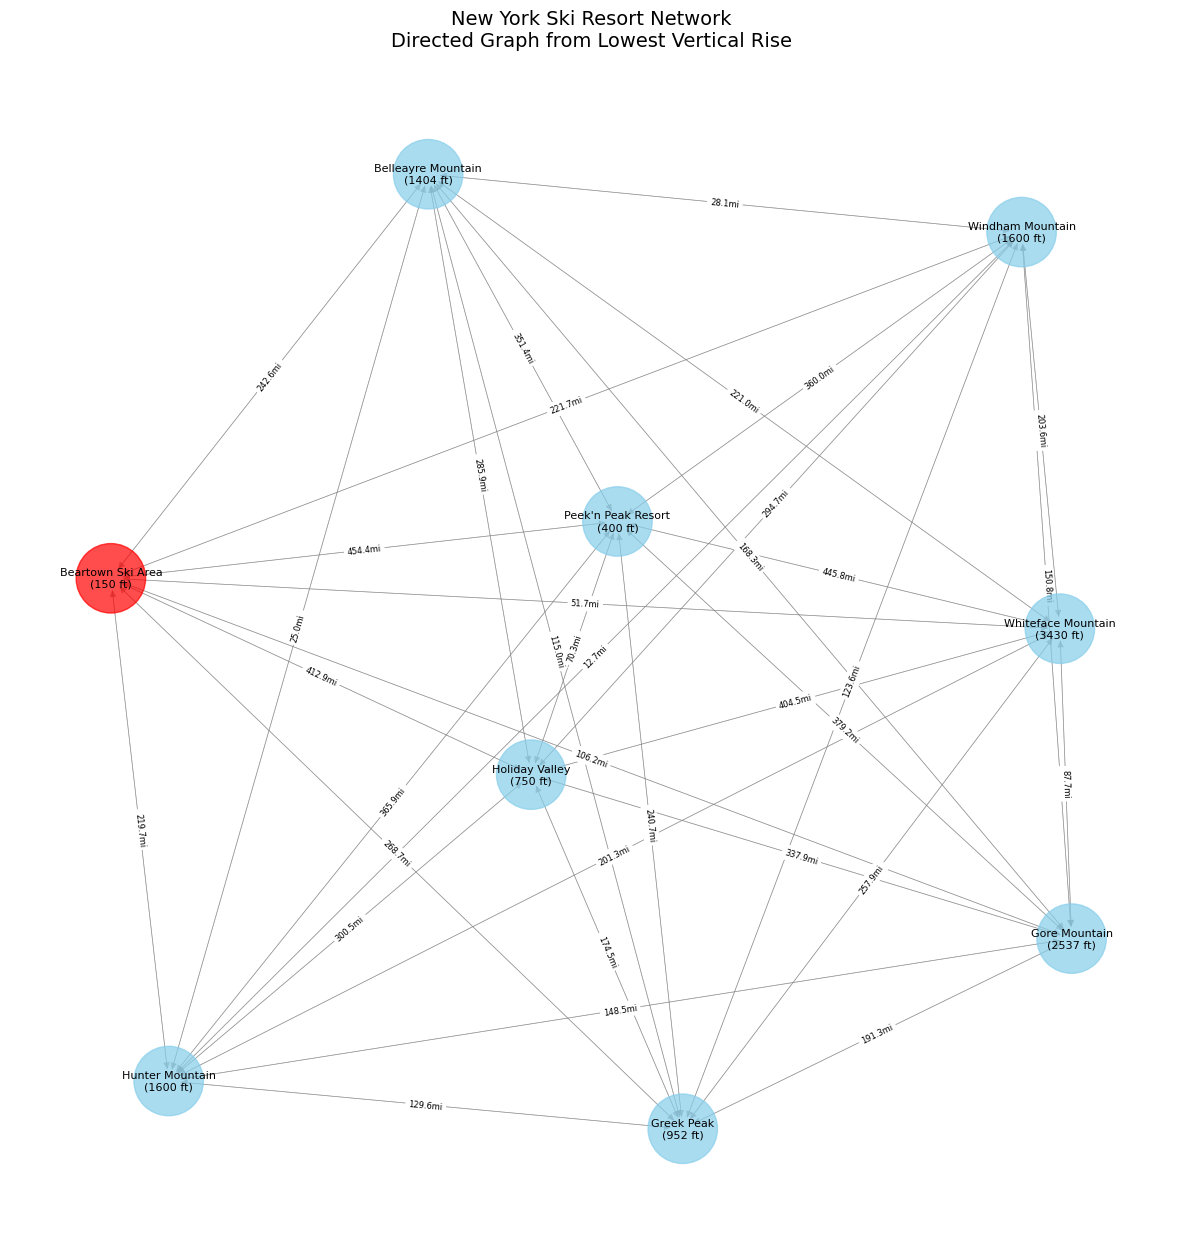

In [16]:
def visualize_ski_network_from_start(df):
    # Create directed graph
    G = nx.DiGraph()
    
    # Find starting point (lowest vertical rise)
    start_idx = df['vertical_rise_num'].idxmin()
    
    # Add nodes (ski resorts)
    for idx, resort in df.iterrows():
        G.add_node(idx, 
                  name=resort['name'],
                  vertical_rise=resort['vertical_rise'])
    
    # Add edges from all points to all other points
    for i in df.index:
        for j in df.index:
            if i != j:  # Do not connect to self
                start = df.loc[i]
                end = df.loc[j]
                route_data = osrm_route(
                    (start['latitude'], start['longitude']),
                    (end['latitude'], end['longitude'])
                )
                G.add_edge(i, j, weight=route_data['distance']) # obtain distance from osrm api and create weight
    
    # Create visualization
    plt.figure(figsize=(15, 15))
    
    # Set layout (only to make the graph appealing, does not affect the edge weight values or routing)
    pos = nx.spring_layout(G, k=2, iterations=50)
    
    # Draw nodes
    node_colors = ['red' if node == start_idx else 'skyblue' for node in G.nodes()]
    nx.draw_networkx_nodes(G, pos,
                          node_color=node_colors,
                          node_size=2500,
                          alpha=0.7)
    
    # Draw edges
    nx.draw_networkx_edges(G, pos,
                          edge_color='gray',
                          width=0.5,
                          alpha=0.6,
                          arrows=True,
                          arrowsize=10)
    
    # Add node labels
    labels = {node: f"{G.nodes[node]['name']}\n({G.nodes[node]['vertical_rise']})" 
             for node in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels, font_size=8)
    
    # Add edge labels (distances)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    edge_labels = {(u,v): f'{w:.1f}mi' for (u,v,w) in G.edges(data='weight')}
    nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=6)
    
    plt.title("New York Ski Resort Network\nDirected Graph from Lowest Vertical Rise", 
              pad=20, fontsize=14)
    plt.axis('off')
    
    # Print network statistics
    print("Network Statistics:")
    print("-" * 50)
    print(f"Starting Resort: {df.loc[start_idx]['name']} (Vertical Rise: {df.loc[start_idx]['vertical_rise']})")
    print(f"Number of Resorts (Nodes): {G.number_of_nodes()}")
    print(f"Number of Possible Routes (Edges): {G.number_of_edges()}")
    
    return G, plt.gcf()

G, fig = visualize_ski_network_from_start(top_9)
plt.show()

In [17]:
def least_distance_route(G, df):
    # Get starting point (lowest vertical rise)
    start_idx = df['vertical_rise_num'].idxmin()
    
    # Initialize variables
    unvisited = set(G.nodes()) - {start_idx}  # Use the actual node indices from the directed graph
    current = start_idx
    route = [current]
    total_distance = 0
    
    # Core Nearest Neighbor loop
    while unvisited:
        # Find distances to unvisited neighbors
        next_distances = {node: G[current][node]['weight'] 
                        for node in unvisited}
        
        # Select closest unvisited neighbor
        next_node = min(next_distances, key=next_distances.get)
        distance = next_distances[next_node]
        
        # Update route
        route.append(next_node)
        total_distance += distance
        current = next_node
        unvisited.remove(current)
    
    return route, total_distance

In [18]:
def visualize_ld_route(df, route):
    all_route_points = []
    
    # Get route geometries from osrm API
    for i in range(len(route)-1):
        start = df.loc[route[i]]
        end = df.loc[route[i+1]]
        
        route_data = osrm_route(
            (start['latitude'], start['longitude']),
            (end['latitude'], end['longitude'])
        )
        decoded_points = polyline.decode(route_data['geometry'])
        all_route_points.append(decoded_points)
    
    # Create figure
    fig = go.Figure()
    
    # Add route lines
    for points in all_route_points:
        lat, lon = zip(*points)
        fig.add_trace(go.Scattermapbox(
            lon=lon,
            lat=lat,
            mode='lines',
            line=dict(width=2, color='blue'),
            hoverinfo='skip'
        ))
    
    # Add resort markers
    resort_lat = []
    resort_lon = []
    resort_names = []
    for i, idx in enumerate(route):
        location = df.loc[idx]    # Changed from iloc to loc
        resort_lat.append(location['latitude'])
        resort_lon.append(location['longitude'])
        resort_names.append(f"Stop {i+1}: {location['name']}")
    
    fig.add_trace(go.Scattermapbox(
        lon=resort_lon,
        lat=resort_lat,
        mode='markers',
        marker=dict(size=12, color=['red' if i == 0 else 'lightblue' for i in range(len(route))]),
        text=resort_names,
        name='Ski Resorts'
    ))
    
    fig.update_layout(
        title='New York Ski Resort - Optimized Route',
        mapbox=dict(
            style="carto-positron",
            center=dict(lat=np.mean(resort_lat), lon=np.mean(resort_lon)),
            zoom=5
        ),
        showlegend=False,
        margin=dict(l=0, r=0, t=30, b=0)
    )
    
    return fig

In [19]:
%%time
route, total_distance = least_distance_route(G, top_9)

CPU times: user 683 μs, sys: 0 ns, total: 683 μs
Wall time: 691 μs


The optimized route generator had a computation time of **1.08 ms** during the reported run.

In [20]:
fig = visualize_ld_route(top_9, route)
fig.show()

print(f"{total_distance:.2f}", "miles")
optimized_route_details = pd.DataFrame(route_details)
optimized_route_details['distance'] = optimized_route_details['distance'].round(2)
display(optimized_route_details)

688.45 miles


,from,to,distance
0,Beartown Ski Area,Greek Peak,268.71
1,Greek Peak,Windham Mountain,123.64
2,Windham Mountain,Whiteface Mountain,203.55
3,Whiteface Mountain,Hunter Mountain,201.25
4,Hunter Mountain,Holiday Valley,300.61
5,Holiday Valley,Peek'n Peak Resort,70.36
6,Peek'n Peak Resort,Gore Mountain,379.17
7,Gore Mountain,Belleayre Mountain,171.27


# Compute time comparison

The computation times in previous versions of the reported runs showed that the optimized route performed far more efficiently when compared to the random route. In fact the random route was taking an average of **4s** to compute. This was due to the OSRM API call functionality not being seperate from the random generation logic. Since then, the random generation logic was isolated in order to perform a fair comparison with the optimized route generation logic. In this reported case, the optimized route computation time is slightly faster than the random route generation.

In [22]:
fig = go.Figure(data=[
    go.Bar(
        x=['Random Route', 'Optimized Route'],
        y=[0.00139, 0.00108],
        marker_color=['#121314', '#28B463'],
        text=[f'{0.00139:.5f}s', f'{0.00108:.5f}s'],
        textposition='auto',
    )
])

# Update layout
fig.update_layout(
    title='Route Computation Time Comparison',
    yaxis_title='Time (seconds)',
    template='plotly_white',
    showlegend=False
)

# Show figure
fig.show()

# Conclusion

The comparison between the random and optimized greedy routes reveals important insights about ski resort route planning in New York. While the random route provides a baseline by arbitrarily connecting resorts from the lowest vertical rise point, the greedy algorithm consistently produces more efficient paths by always selecting the closest unvisited resort. This optimization significantly reduces the total travel distance, making it more practical for skiers planning multi-resort trips. However, it's worth noting that while the greedy approach improves upon random selection, it may not always find the globally optimal solution since it makes locally optimal choices at each step without considering the entire path.